In [1]:
!pip install google_auth_oauthlib 
!pip install install google-api-python-client
!pip install pandas 
!pip install numpy
!pip install matplotlib


In [1]:
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from IPython.display import display
import os
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



#DEV GUIDES
#https://developers.google.com/analytics/devguides/reporting
    
!gcloud config get-value account


dave@clevercanary.com


In [2]:
ANALYTICS_REPORTING_CLIENT_SECRET_PATH=os.getenv('ANALYTICS_REPORTING_CLIENT_SECRET_PATH')
print(ANALYTICS_REPORTING_CLIENT_SECRET_PATH)

flow = InstalledAppFlow.from_client_secrets_file(ANALYTICS_REPORTING_CLIENT_SECRET_PATH,
    scopes=['https://www.googleapis.com/auth/analytics.readonly'])

credentials = flow.run_local_server()

# Build the service object.
service = build('analytics', 'v3', credentials=credentials)
accounts = service.management().accounts().list().execute()



/Users/dave/Downloads/analytics-reporting-dave-client_secret_713613812354-4nlori99e34rebtiup7ch8gcpgk40kbn.apps.googleusercontent.com.json
Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=713613812354-4nlori99e34rebtiup7ch8gcpgk40kbn.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fanalytics.readonly&state=AowTgfST7GSo50Dh5U9A2i7GDJ99so&access_type=offline


In [3]:

## HCA Data Portal/Browser
PROPERTY = "185740629"
DCP_ANALYTICS_START = "2019-02-28"
TODAY = 'today'


def results_to_df(results):

  # Collect column nmes 
  column_names = []
  for header in results.get('columnHeaders'):
    column_names.append(header.get('name'))

  # Get data  
  data = results.get('rows')

  # Crete the dataframe
  df = pd.DataFrame(data, columns = column_names)

  return df

2019-03-01 today


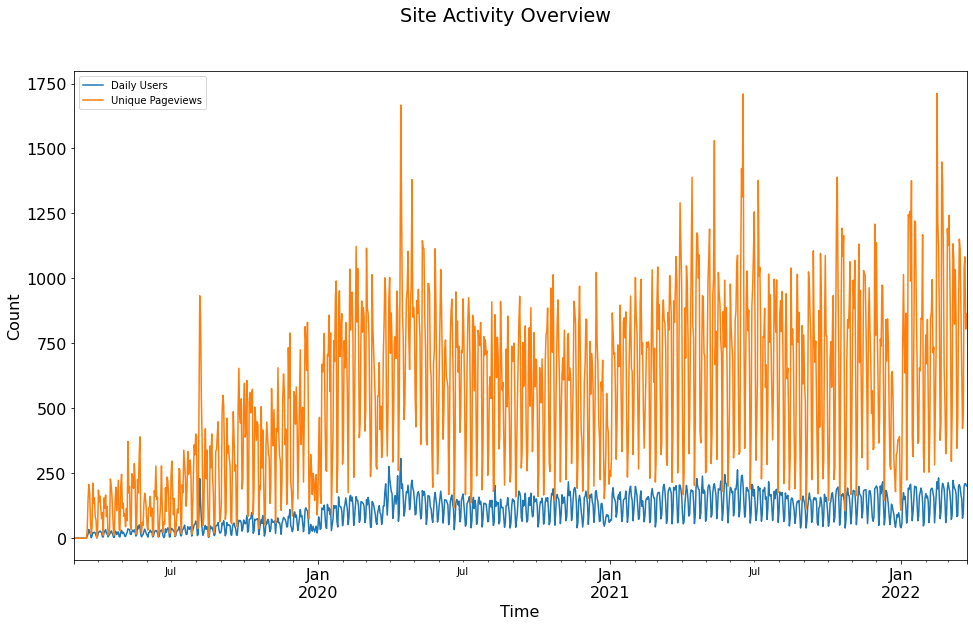

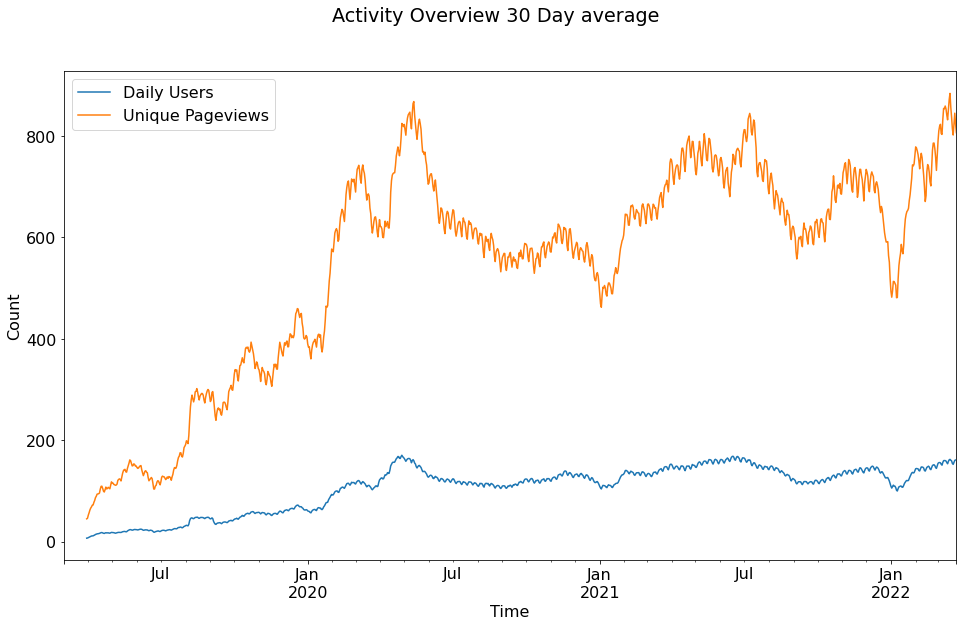

Daily Users  Unique Pageviews  Daily Users % Change  \
Year Quarter                                                        
2019 1                212              1383                   NaN   
     2               1872             11485            783.018868   
     3               3677             24289             96.420940   
     4               5420             34251             47.402774   
2020 1               9889             57200             82.453875   
     2              12609             65887             27.505309   
     3              10510             53574            -16.646840   
     4              11189             50930              6.460514   
2021 1              12480             59957             11.538118   
     2              14226             68920             13.990385   
     3              11926             60388            -16.167580   
     4              11923             59237             -0.025155   
2022 1              12445             64948              4.378093   

              Unique Pageviews % Change  
Year Quarter                             
2019 1                              NaN  
     2                       730.441070  
     3                       111.484545  
     4                        41.014451  
2020 1                        67.002423  
     2                        15.187063  
     3                       -18.688057  
     4                        -4.935230  
2021 1                        17.724328  
     2                        14.949047  
     3                       -12.379571  
     4                        -1.906008  
2022 1                         9.640934

In [4]:

## HCA Data Portal/Browser
PROPERTY = "185740629"
DCP_ANALYTICS_START = "2019-03-01"
TODAY = 'today'


def results_to_df(results):
  
    df = pd.DataFrame()
    for result in results:  
        # Collect column nmes 
        column_names = []
        for header in result.get('columnHeaders'):
            column_names.append(header.get('name'))

        # Get data  
        data = result.get('rows')

        # Crete the dataframe
        df = df.append(pd.DataFrame(data, columns = column_names))

    return df

def get_metrics_by_dimensions(metrics, dimensions, start_date, end_date):
    # Dimensions and Metrics... 
    # Dimensions are atrributes, Metrics are quantitative measurements. e.g. city is a Dimension
    # Sessions  is a metric.
    #https://support.google.com/analytics/answer/1033861?hl=en#site-search-attribution&zippy=%2Cin-this-article
    
    params = {
        'ids':'ga:' + PROPERTY,
        'start_date':start_date,
        'end_date':end_date,
        'dimensions':dimensions,
        'metrics':metrics,
        'start_index':1,
        'max_results':1000
    }

    results = []
    has_more = True

    while has_more:
        result = service.data().ga().get(**params).execute()
        results.append(result)
        has_more = result.get('nextLink')
        params['start_index']+= params['max_results'] 
    
    df =  results_to_df(results)

    return df
    

def plot_users_over_time(start_date, end_date):
    
    metrics = 'ga:1dayUsers, ga:uniquePageviews'
    dimensions = 'ga:date'
    print(start_date, end_date)
    df = get_metrics_by_dimensions(metrics,dimensions, start_date, end_date)

    # Convert date to datetime object
    df["ga:date"] = pd.to_datetime(df['ga:date'])
    df.set_index('ga:date', inplace=True)
    
    # Convert strings returned by API to integers. Can we do this earlier!
    # If not numeric data the series won't graph
    df["ga:1dayUsers"] = df['ga:1dayUsers'].astype(str).astype(int)
    df["ga:uniquePageviews"] = df['ga:uniquePageviews'].astype(str).astype(int)

  
    # Rename for display
    df.rename(columns={'ga:1dayUsers':'Daily Users', 'ga:uniquePageviews':'Unique Pageviews'}, inplace=True)
    
    #Smooth (coiuld we not just use 7 day users then?)
#     df = df.rolling(window=1).mean() 
    
    # Notes: Linking Mandas and Matplotlib
    # https://stackoverflow.com/questions/29568110/how-to-use-ax-with-pandas-and-matplotlib

    fontsize=16
    fig, ax = plt.subplots(figsize=(16, 9))
    df.plot(ax=ax) #Link the df with the axis
    
    ax.set_xlabel('Time', fontsize=fontsize)
    ax.set_ylabel('Count', fontsize=fontsize);  

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize)
    
    plt.rcParams['font.size'] = fontsize
    fig.suptitle('Site Activity Overview')
    plt.show()
    
    # Average per qurter
    
    dfmean = df.rolling(window=30).mean()
    fig, ax = plt.subplots(figsize=(16, 9))
    dfmean.plot(ax=ax) #Link the df with the axis
    
    ax.set_xlabel('Time', fontsize=fontsize)
    ax.set_ylabel('Count', fontsize=fontsize);  

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize)
    
    plt.rcParams['font.size'] = fontsize
    fig.suptitle('Activity Overview 30 Day average')
    plt.show()
    
            
    df2 = df.copy(deep=True)
    df2['Quarter'] = df2.index.quarter
    df2['Year'] = df2.index.year
    
    df2 = df2.groupby(['Year','Quarter']).sum()
    df2['Daily Users % Change'] = df2['Daily Users'].pct_change().mul(100)
    df2['Unique Pageviews % Change'] = df2['Unique Pageviews'].pct_change().mul(100)
    
    display(df2)


def plot_hbar(title, xlabel, ylabel, metric, dimension, start_date, end_date):
  df = get_metrics_by_dimensions(metric,dimension, start_date, end_date)
  df.set_index(dimension, inplace=True)
  df[metric] = df[metric].astype(str).astype(int)
  df = df.sort_values(by=[metric]).tail(25)
  df.plot.barh()
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.style.use('_mpl-gallery')
  plt.show()

plot_users_over_time(DCP_ANALYTICS_START,TODAY)

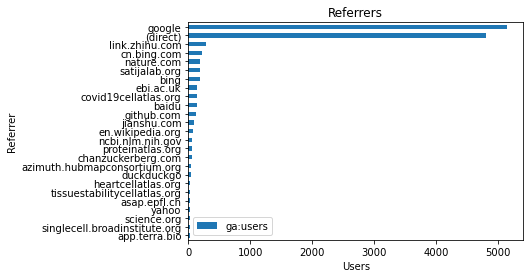

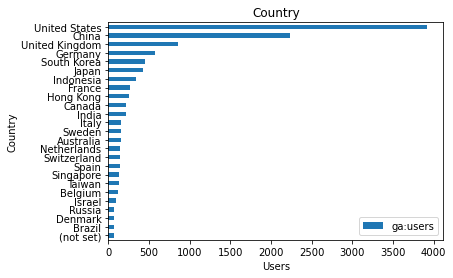

In [7]:
plot_hbar("Referrers", "Users", "Referrer", "ga:users","ga:source", '120daysAgo',"today")
plot_hbar("Country", "Users", "Country", "ga:users","ga:country", '120daysAgo',"today")


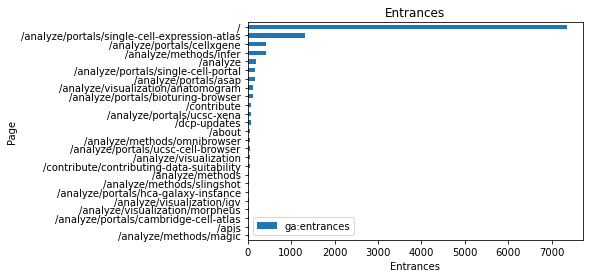

In [8]:
plot_hbar("Entrances", "Entrances", "Page", "ga:entrances","ga:pagePath", '120daysAgo',"today")
